In [1]:
import numpy as np
import pandas as pd
import cufflinks as cf
cf.go_offline()
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from functools import partial
import plotnine

In [2]:
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
order_products_train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
#sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
test_df = (orders[orders['eval_set']=='test']
          .reset_index()
          .drop(['index', 'eval_set'], axis=1))

In [4]:
prior_df = (orders[orders['eval_set']=='prior']
          .reset_index()
          .drop(['index', 'eval_set'], axis=1))

In [5]:
train_df = (orders[orders['eval_set']=='train']
          .reset_index()
          .drop(['index', 'eval_set'], axis=1))

In [6]:
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')

In [7]:
goods.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id department                       aisle  
0             19     snacks               cookies cakes  
1             13     pantry           spices seasonings  
2              7  beverages                         tea  
3              1     frozen                frozen meals  
4             13     pantry  marinades meat preparation

In [8]:
dep = (goods.groupby('department').count()['product_id']
              .sort_values(ascending=False).to_frame()
              .reset_index())
dep

department  product_id
0     personal care        6563
1            snacks        6264
2            pantry        5371
3         beverages        4365
4            frozen        4007
5        dairy eggs        3449
6         household        3085
7      canned goods        2092
8   dry goods pasta        1858
9           produce        1684
10           bakery        1516
11             deli        1322
12          missing        1258
13    international        1139
14        breakfast        1115
15           babies        1081
16          alcohol        1054
17             pets         972
18     meat seafood         907
19            other         548
20             bulk          38

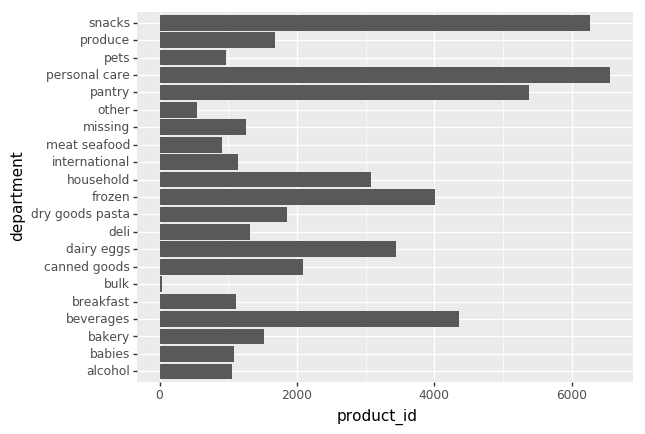

<ggplot: (8790875725632)>

In [11]:
# 각 Department에 상품이 몇 개씩 있는가 -> 상품이 많으면 그 department가 쇼핑 목록에 들어갈 확률이 높아진다.
from plotnine import *
(ggplot(dep, aes('department', 'product_id'))
 +geom_bar(stat='identity')
 +coord_flip())

In [ ]:
# 각 Department에 상품이 몇 개씩 있는가 -> 상품이 많으면 그 department가 쇼핑 목록에 들어갈 확률이 높아진다.
(goods.groupby('department')
 .count()['product_id']
 .sort_values(ascending=False)
 .iplot(kind='bar', title='각 Department에 속한 상품의 개수'))

In [12]:
part_aisle = (goods.groupby('aisle').count()['product_id']
              .sort_values(ascending=False)[:15].to_frame()
              .reset_index())
part_aisle

aisle  product_id
0                missing        1258
1        candy chocolate        1246
2          ice cream ice        1091
3   vitamins supplements        1038
4                 yogurt        1026
5         chips pretzels         989
6                    tea         894
7        packaged cheese         891
8           frozen meals         880
9          cookies cakes         874
10   energy granola bars         832
11             hair care         816
12     spices seasonings         797
13         juice nectars         792
14              crackers         747

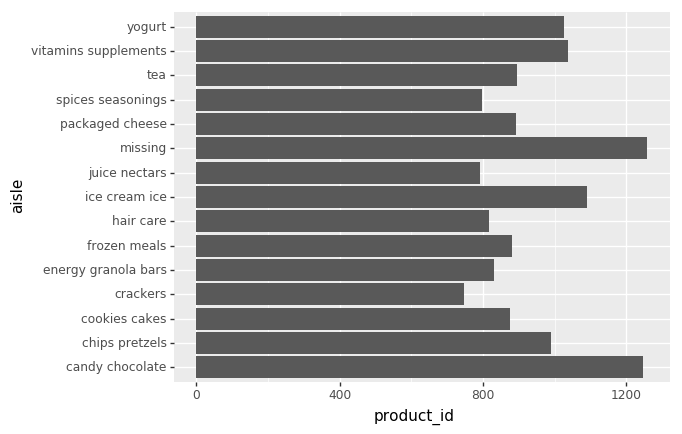

<ggplot: (-9223363245979090863)>

In [13]:
# 각 aisle에 상품이 몇 개씩 있는가 -> 상품이 많으면 그 aisle이 쇼핑 목록에 들어갈 확률이 높아진다.
from plotnine import *
(ggplot(part_aisle, aes('aisle', 'product_id'))
 +geom_bar(stat='identity')
 +coord_flip())

In [ ]:
# 각 aisle에 상품이 몇 개씩 있는가 -> 상품이 많으면 그 aisle이 쇼핑 목록에 들어갈 확률이 높아진다.
(goods.groupby('aisle')
.count()['product_id']
.sort_values(ascending=False)[:15]
.iplot(kind='bar', title='각 Aisle에 속한 상품의 개수'))

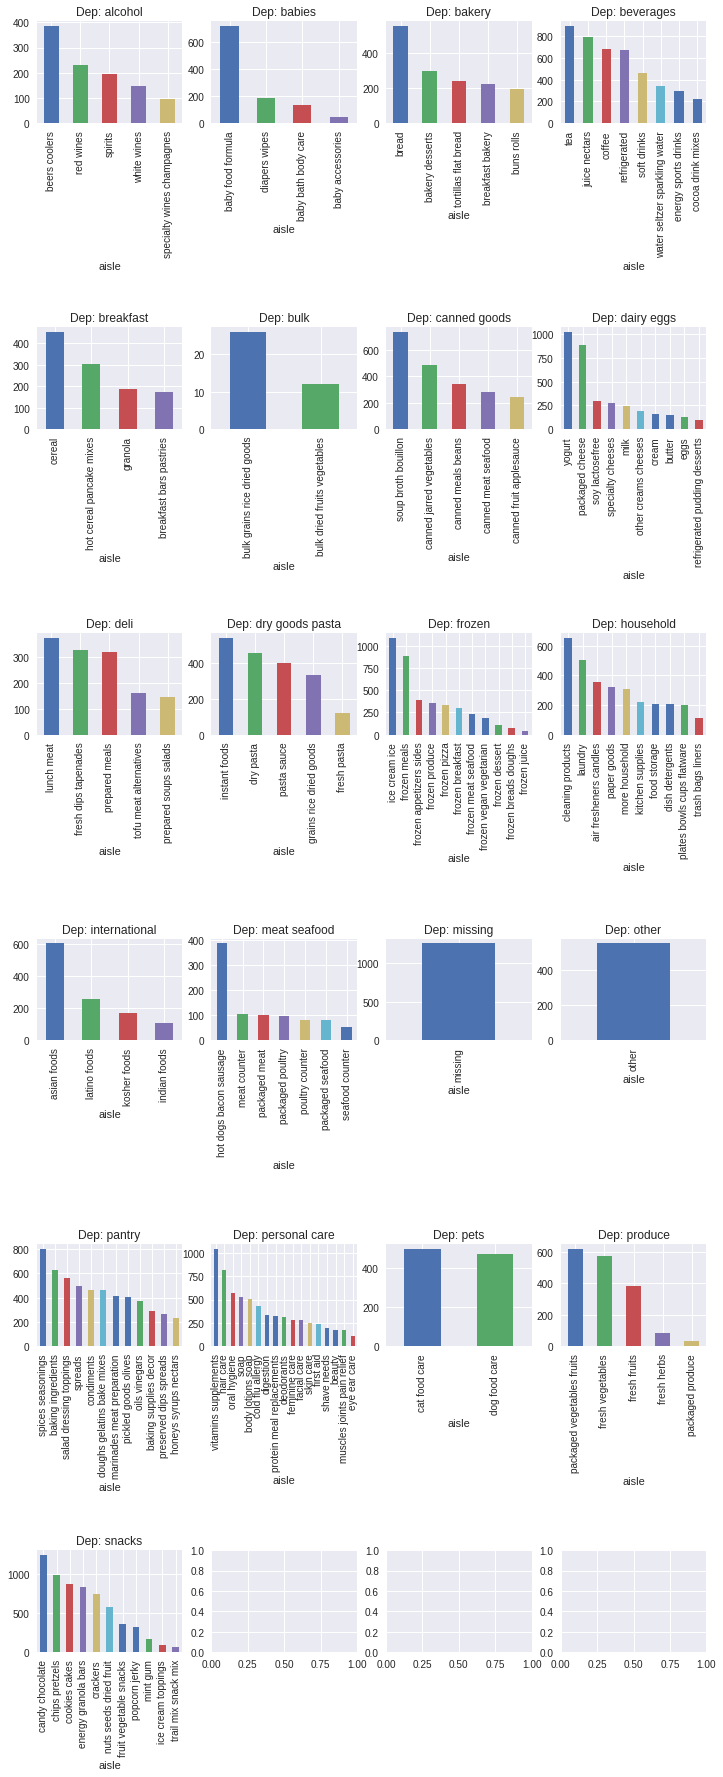

In [14]:
# 한 커널에서 참고했습니다...ㅎㅎㅎ.....
# 각 department 내에서 다시 aisle 별로 구분하여 상품의 개수가 몇개인지 표현
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

In [15]:
from functools import partial

prior_detail = pd.merge(left=prior_df, 
                        right=order_products_prior,
                       how='left', on='order_id').apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

prior_detail = pd.merge(left=prior_detail,
                       right=goods[['product_id', 'aisle_id', 'department_id']],
                       how='left',
                       on='product_id').apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))

In [16]:
# prior detail이 너무 커서 sample 500개만 추출
prior_detail_sample = prior_detail.sample(500)

In [17]:
from functools import partial

train_detail = pd.merge(left=train_df, 
                        right=order_products_train,
                       how='left', on='order_id')

train_detail = pd.merge(left=train_detail,
                       right=goods[['product_id', 'aisle_id', 'department_id']],
                       how='left',
                       on='product_id')

In [18]:
#orders 있던 것처럼 test data만 빼고 prior sample + train
order_detail = pd.concat([prior_detail_sample, train_detail], axis=0)
order_detail = order_detail.reset_index()

In [19]:
top = (train_detail.groupby('product_id')
.size()
.sort_values(ascending=False)[:10]
)

In [24]:
top

product_id
24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
47766     7409
47209     7293
16797     6494
26209     6033
27966     5546
dtype: int64

In [ ]:
# ....또 합치기 싫어서 하나씩 다 썼습니다.....ㅎ 10개만 하면 되니까요!.....ㅠ

In [20]:
number=['18276', '15480', '10894', '9784', '8135', '7409', '7293', '6494', '6033', '5546']
product_name=['banana', 'bag of organic bananas', 'organic strawberries', 'organic baby spinach', 'large lemon', 'organic avocado', 'organic hass avocado', 'strawberries', 'limes', 'organic rasberries'] 
top10_product = pd.DataFrame(number, product_name).reset_index()
top10_product.columns = ['product_name', 'number']

In [21]:
top10_product

product_name number
0                  banana  18276
1  bag of organic bananas  15480
2    organic strawberries  10894
3    organic baby spinach   9784
4             large lemon   8135
5         organic avocado   7409
6    organic hass avocado   7293
7            strawberries   6494
8                   limes   6033
9      organic rasberries   5546

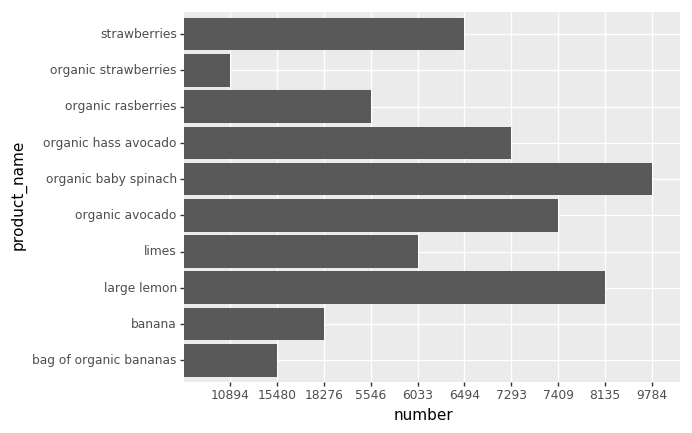

<ggplot: (8790875674951)>

In [22]:
# 가장 판매량이 많은 상위 10개 상품
from plotnine import *
(ggplot(top10_product, aes('product_name', 'number'))
+geom_bar(stat='identity')
+coord_flip())

In [ ]:
# 가장 판매량이 많은 상위 10개 상품
top10_product.iplot(kind='bar', title='Popular Products')

In [23]:
order_detail['aisle_id'].value_counts().head(10)

83     150668
24     150539
123     78518
120     55267
21      41708
115     36624
84      32653
107     31282
91      26252
112     23649
Name: aisle_id, dtype: int64

In [28]:
pop_aisle = ['fresh vegetables', 'fresh fruits', 'packaged vegetables fruits', 'yogurt', 'packaged cheese'
             , 'water seltzer sparkling water', 'milk', 'chips pretzels', 'soy lactosefree', 'bread']
num_aisle = ['150658', '150527', '78529', '55267', '41709' ,'36635', '32662', '31282', '26248', '23647']
top10_aisle = pd.DataFrame(num_aisle, pop_aisle).reset_index()
top10_aisle.columns = ['pop_aisle', 'num_aisle']

In [29]:
top10_aisle

pop_aisle num_aisle
0               fresh vegetables    150658
1                   fresh fruits    150527
2     packaged vegetables fruits     78529
3                         yogurt     55267
4                packaged cheese     41709
5  water seltzer sparkling water     36635
6                           milk     32662
7                 chips pretzels     31282
8                soy lactosefree     26248
9                          bread     23647

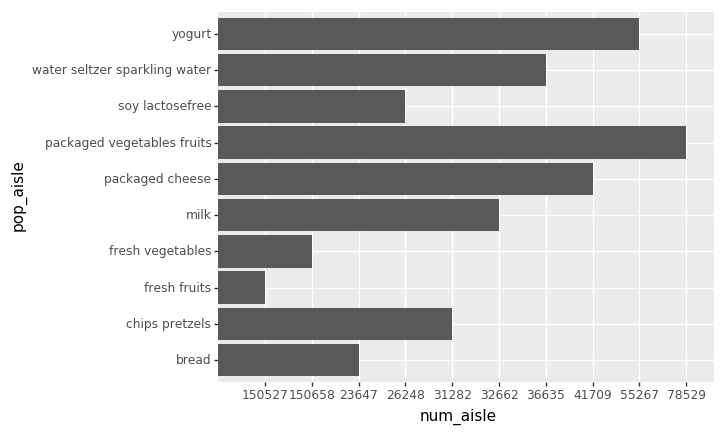

<ggplot: (-9223363246162417043)>

In [30]:
# 가장 판매량이 많은 상위 10개 aisle
from plotnine import *
(ggplot(top10_aisle, aes('pop_aisle', 'num_aisle'))
+geom_bar(stat='identity')
+coord_flip())

In [ ]:
# 가장 판매량이 많은 상위 10개 aisle
top10_aisle.iplot(kind='bar')

In [31]:
order_detail['department_id'].value_counts().head(10)

4     409246
16    217125
19    118903
7     114092
1     100460
13     81268
3      48412
15     46813
20     44310
9      38729
Name: department_id, dtype: int64

In [32]:
pop_dep = ['produce', 'dairy eggs', 'snacks', 'beverages', 'frozen', 'pantry', 'bakery', 'canned goods', 'deli', 'dry goods pasta']
num_dep = ['409236', '217138', '118912', '114085', '100455', '81265', '48413', '46814', '44308', '38727']
top10_department = pd.DataFrame(num_dep, pop_dep).reset_index()
top10_department.columns = ['pop_dep', 'num_dep']

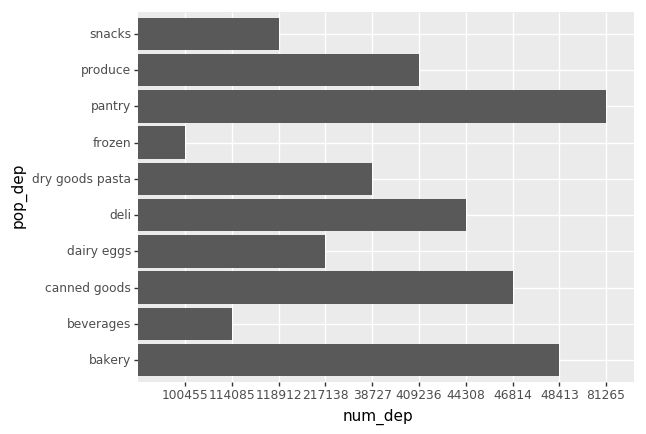

<ggplot: (8790705282652)>

In [33]:
# 가장 판매량 많은 상위 10개 department
from plotnine import *
(ggplot(top10_department, aes('pop_dep', 'num_dep'))
+geom_bar(stat='identity')
+coord_flip())

In [ ]:
# 가장 판매량 많은 상위 10개 department
top10_department.iplot(kind='bar')

In [34]:
num_order = (order_detail.groupby("order_id")["add_to_cart_order"]
 .aggregate(np.max).reset_index()['add_to_cart_order'].value_counts().to_frame().reset_index())

In [35]:
#근데 한번 주문에 100개가 넘는게 말이 되나....?
num_order

index  add_to_cart_order
0       5               8930
1       6               8744
2       7               8576
3       4               8262
4       3               8065
5       8               8013
6       2               7406
7       9               7243
8       1               6896
9      10               6575
10     11               6057
11     12               5401
12     13               4860
13     14               4407
14     15               3848
15     16               3528
16     17               3115
17     18               2727
18     19               2478
19     20               2108
20     21               1860
21     22               1687
22     23               1465
23     24               1293
24     25               1082
25     26                989
26     27                863
27     28                681
28     29                636
29     30                553
..    ...                ...
45     47                 49
46     46                 48
47     48                 32
48     50                 31
49     49                 26
50     51                 24
51     52                 23
52     53                 18
53     54                 15
54     55                 12
55     56                 10
56     60                  8
57     57                  6
58     58                  5
59     63                  5
60     70                  4
61     59                  4
62     64                  4
63     61                  3
64     62                  3
65     65                  3
66     72                  3
67     76                  2
68     74                  2
69     80                  2
70     68                  2
71     66                  2
72     67                  1
73     75                  1
74     77                  1

[75 rows x 2 columns]

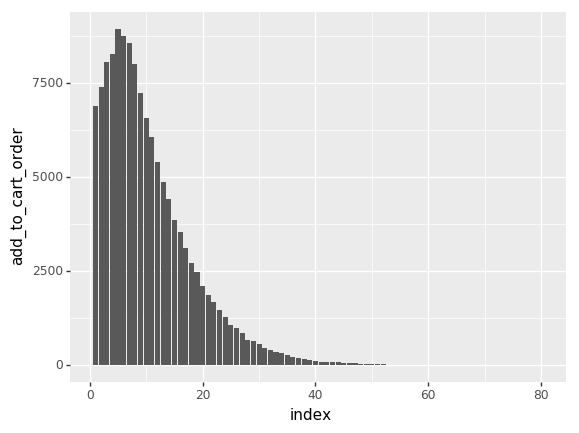

<ggplot: (8790692302144)>

In [36]:
# 한 번 주문할 때 몇 개의 상품을 주문하는가
#여기서 x축 index는 한번에 주문한 상품의 갯수, y축 add_to_cart_order는 그 갯수만큼 주문이 몇 번 들어왔는가
#각 숫자가 정확히 안떠서 커프링스가 더 나은듯
from plotnine import *
(ggplot(num_order, aes('index', 'add_to_cart_order'))
+geom_bar(stat='identity')
)

In [ ]:
# 한 번 주문할 때 몇 개의 상품을 주문하는가
num_order2 = (order_detail.groupby("order_id")["add_to_cart_order"]
 .aggregate(np.max).reset_index()['add_to_cart_order'].value_counts())
num_order2.iplot(kind='bar')

In [37]:
day = orders.groupby('order_dow').size().sort_values().to_frame().reset_index()
day.columns = ['order_dow', 'orders']
day

order_dow  orders
0          4  426339
1          3  436972
2          6  448761
3          5  453368
4          2  467260
5          1  587478
6          0  600905

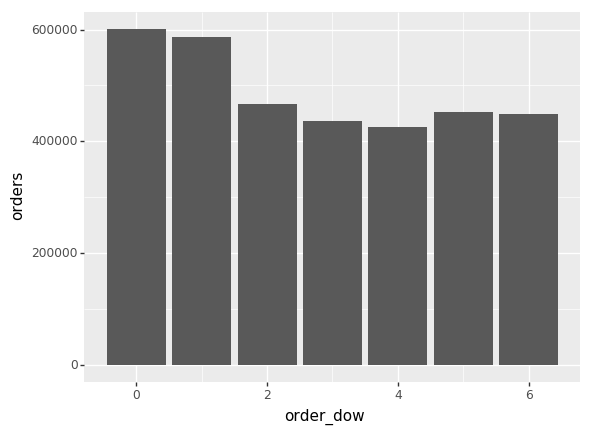

<ggplot: (8790692278241)>

In [38]:
#무슨 요일에 주문이 많이 들어오는지 -> 거의 비슷한데 0,1로 표시된 이틀의 주문량이 가장 많음. 아마 주말일 것으로 예상
from plotnine import *
(ggplot(day, aes('order_dow', 'orders'))
+geom_bar(stat='identity')
)

In [ ]:
#무슨 요일에 주문이 많이 들어오는지 -> 거의 비슷한데 0,1로 표시된 이틀의 주문량이 가장 많음. 아마 주말일 것으로 예상
(orders.groupby('order_dow')
.size()
.sort_values()
.iplot(kind='bar', title='요일별 주문량'))

In [39]:
hour = orders.groupby('order_hour_of_day').size().sort_values().to_frame().reset_index()
hour.columns = ['order_hour_of_day', 'orders']
hour

order_hour_of_day  orders
0                   3    5474
1                   4    5527
2                   2    7539
3                   5    9569
4                   1   12398
5                   0   22758
6                   6   30529
7                  23   40043
8                  22   61468
9                  21   78109
10                  7   91868
11                 20  104292
12                 19  140569
13                  8  178201
14                 18  182912
15                 17  228795
16                  9  257812
17                 16  272553
18                 12  272841
19                 13  277999
20                 14  283042
21                 15  283639
22                 11  284728
23                 10  288418

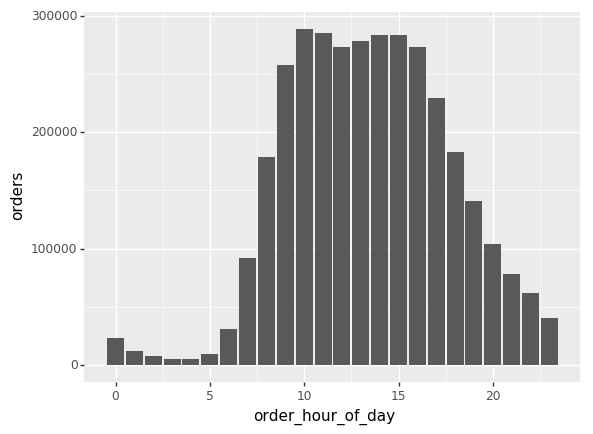

<ggplot: (8790692334600)>

In [40]:
# 무슨 시간대에 주문이 많이 들어오는지 -> 낮~오후(약 9시~17시) 시간대에 주문량이 많다.
from plotnine import *
(ggplot(hour, aes('order_hour_of_day', 'orders'))
+geom_bar(stat='identity')
)

In [ ]:
# 무슨 시간대에 주문이 많이 들어오는지 -> 낮~오후(약 9시~17시) 시간대에 주문량이 많다.
(orders.groupby('order_hour_of_day')
.size()
.sort_values()
.iplot(kind='bar', title='시간대별 주문량'))

In [41]:
days_after = orders.groupby('days_since_prior_order').size().sort_values().to_frame().reset_index()
days_after.columns = ['days_since_prior_order', 'orders']
days_after

days_since_prior_order  orders
0                     26.0   19016
1                     29.0   19191
2                     25.0   19234
3                     24.0   20712
4                     27.0   22013
5                     23.0   23885
6                     28.0   26777
7                     22.0   32012
8                     19.0   34384
9                     18.0   35881
10                    20.0   38527
11                    17.0   39245
12                    21.0   45470
13                    16.0   46941
14                    15.0   66579
15                     0.0   67755
16                    12.0   76146
17                    11.0   80970
18                    13.0   83214
19                    10.0   95186
20                    14.0  100230
21                     9.0  118188
22                     1.0  145247
23                     8.0  181717
24                     2.0  193206
25                     5.0  214503
26                     3.0  217005
27                     4.0  221696
28                     6.0  240013
29                     7.0  320608
30                    30.0  369323

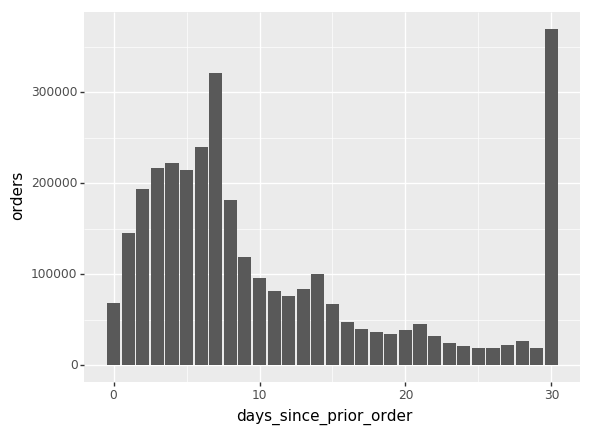

<ggplot: (8790676050233)>

In [42]:
# 재구매는 이전 주문으로부터 몇일 이후 가장 많은가 
# -> 주로 10일 이전에 많이 주문을 하지만, 단독 날짜로 보았을 때는 한 달 이후 주문 했을 때 주문량이 가장 많다.
from plotnine import *
(ggplot(days_after, aes('days_since_prior_order', 'orders'))
+geom_bar(stat='identity')
)

In [ ]:
# 재구매는 이전 주문으로부터 몇일 이후 가장 많은가 
# -> 주로 10일 이전에 많이 주문을 하지만, 단독 날짜로 보았을 때는 한 달 이후 주문 했을 때 주문량이 가장 많다.
(orders.groupby('days_since_prior_order')
.size()
.sort_values()
.iplot(kind='bar', title='재구매 날짜에 따른 주문량'))

In [43]:
test_df.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   2774568        3            13          5                 15   
1    329954        4             6          3                 12   
2   1528013        6             4          3                 16   
3   1376945       11             8          6                 11   
4   1356845       12             6          1                 20   

   days_since_prior_order  
0                    11.0  
1                    30.0  
2                    22.0  
3                     8.0  
4                    30.0

In [ ]:
#test set에 속하는 주문이 들어오면 무슨 상품들이 팔리게 될까
#add-to-cart-order: 주문한 상품 갯수 / product_id / reordered?...

In [117]:
goods.head(10)

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   
5           6                                       Dry Nose Oil        11   
6           7                     Pure Coconut Water With Orange        98   
7           8                  Cut Russet Potatoes Steam N' Mash       116   
8           9                  Light Strawberry Blueberry Yogurt       120   
9          10     Sparkling Orange Juice & Prickly Pear Beverage       115   

   department_id     department                          aisle  
0             19         snacks                  cookies cakes  
1             13         pantry              spices seasonings  
2              7      beverages                            tea  
3              1         frozen                   frozen meals  
4             13         pantry     marinades meat preparation  
5             11  personal care               cold flu allergy  
6              7      beverages                  juice nectars  
7              1         frozen                 frozen produce  
8             16     dairy eggs                         yogurt  
9              7      beverages  water seltzer sparkling water

In [45]:
order_detail.head()

index  order_id  user_id  order_number  order_dow  order_hour_of_day  \
0  19849975   2947428   125851             4          0                  9   
1  27753784   2773499   176390             3          4                  1   
2   1312935   1610339     8477             8          1                  9   
3  21489851   1487477   136508            32          5                 18   
4  20736299    939937   131753            14          0                 22   

   days_since_prior_order  product_id  add_to_cart_order  reordered  aisle_id  \
0                    30.0       44548                  4          0       107   
1                    14.0       27355                  3          0       129   
2                    12.0       22307                  5          1        78   
3                     1.0       39954                  3          1        88   
4                     7.0        7185                  8          1        78   

   department_id  
0             19  
1              1  
2             19  
3             13  
4             19

In [46]:
Order_detail = order_detail

In [ ]:
#Feature Engineering ............ 종속변수와 독립 변수 사이의 관계 측정이 쉽지 않아보임 -> 한 주문에 해당하는 상품의 개수가 하나가 아니어서!...
#scatter plot 그릴만한 변수 조합도 마땅치 않음...ㅠㅠ
#hour / day / days since~ 구획 짓기 -> 이렇게 하면 숫자가 클 수록 add-to-cart-order가 커질 것

In [88]:
#day 구획 -> 가장 주문량이 많은 0과 1은 1로, 나머지는 0으로 묶음
a = Order_detail['order_dow'].tolist()

b = []


for x in a:
    if x==0 or x==1:
        b.append(1)
    else:
        b.append(0)
        
Order_detail['re-dow'] = b

In [89]:
#hour 구획 -> 주문량이 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
c = Order_detail['order_hour_of_day'].tolist()

d = []

hour1 = [9,10,11,12,13,14,15,16,17]
hour2 = [8,18,19,20]

for x in c:
    if x in hour1:
        d.append(2)
    elif x in hour2:
        d.append(1)
    else:
        d.append(0)
        
Order_detail['re-hour'] = d

In [91]:
#days since prior order 구획 -> 주문량이 30만 이상이면 3, 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
e = Order_detail['days_since_prior_order'].tolist()

f = []

day1=[7,30]
day2=[3,4,5,6]
day3=[1,2,9]

for x in e:
    if x in day1:
        f.append(3)
    elif x in day2:
        f.append(2)
    elif x in day3:
        f.append(1)
    else:
        f.append(0)
        
Order_detail['re-after days'] = f

In [94]:
Order_detail = Order_detail.drop(['order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis=1)

In [95]:
Order_detail.head()

index  order_id  user_id  order_number  product_id  add_to_cart_order  \
0  19849975   2947428   125851             4       44548                  4   
1  27753784   2773499   176390             3       27355                  3   
2   1312935   1610339     8477             8       22307                  5   
3  21489851   1487477   136508            32       39954                  3   
4  20736299    939937   131753            14        7185                  8   

   reordered  aisle_id  department_id  re-dow  re-hour  re-after days  
0          0       107             19       1        2              3  
1          0       129              1       0        0              0  
2          1        78             19       1        2              0  
3          1        88             13       0        1              1  
4          1        78             19       1        0              3

In [102]:
Test_df = test_df

In [103]:
#day 구획 -> 가장 주문량이 많은 0과 1은 1로, 나머지는 0으로 묶음
a = Test_df['order_dow'].tolist()

b = []


for x in a:
    if x==0 or x==1:
        b.append(1)
    else:
        b.append(0)
        
Test_df['re-dow'] = b

In [104]:
#hour 구획 -> 주문량이 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
c = Test_df['order_hour_of_day'].tolist()

d = []

hour1 = [9,10,11,12,13,14,15,16,17]
hour2 = [8,18,19,20]

for x in c:
    if x in hour1:
        d.append(2)
    elif x in hour2:
        d.append(1)
    else:
        d.append(0)
        
Test_df['re-hour'] = d

In [105]:
#days since prior order 구획 -> 주문량이 30만 이상이면 3, 20만 이상이면 2, 10만 이상이면 1, 나머지는 0
e = Test_df['days_since_prior_order'].tolist()

f = []

day1=[7,30]
day2=[3,4,5,6]
day3=[1,2,9]

for x in e:
    if x in day1:
        f.append(3)
    elif x in day2:
        f.append(2)
    elif x in day3:
        f.append(1)
    else:
        f.append(0)
        
Test_df['re-after days'] = f

In [106]:
Test_df = Test_df.drop(['order_dow', 'order_hour_of_day', 'days_since_prior_order'], axis=1)

In [107]:
Test_df.head()

order_id  user_id  order_number  re-dow  re-hour  re-after days
0   2774568        3            13       0        2              0
1    329954        4             6       0        2              3
2   1528013        6             4       0        2              0
3   1376945       11             8       0        2              0
4   1356845       12             6       1        1              3

In [ ]:
#product별 reordered 비율 구하기
#Order_detail data는 train_detail을 sample(500)했기 때문에 모든 데이터에 대한 정보가 없음
#결국 전체 데이터 합치고 해보기...

In [123]:
full_detail = pd.concat([train_detail, prior_detail], axis=0)

In [124]:
full_detail.head()

order_id  user_id  order_number  order_dow  order_hour_of_day  \
0   1187899        1            11          4                  8   
1   1187899        1            11          4                  8   
2   1187899        1            11          4                  8   
3   1187899        1            11          4                  8   
4   1187899        1            11          4                  8   

   days_since_prior_order  product_id  add_to_cart_order  reordered  aisle_id  \
0                    14.0         196                  1          1        77   
1                    14.0       25133                  2          1        21   
2                    14.0       38928                  3          1       120   
3                    14.0       26405                  4          1        54   
4                    14.0       39657                  5          1        45   

   department_id  
0              7  
1             16  
2             16  
3             17  
4             19

In [125]:
reorder_ratio = full_detail.groupby('product_id')['reordered'].mean().to_frame().reset_index()

In [129]:
reorder_ratio.columns = ['product_id', 'reordered_ratio']
reorder_ratio.head(20)

product_id  reordered_ratio
0            1         0.614627
1            2         0.138298
2            3         0.738516
3            4         0.458689
4            5         0.625000
5            6         0.375000
6            7         0.419355
7            8         0.505618
8            9         0.521739
9           10         0.510591
10          11         0.566038
11          12         0.509653
12          13         0.300000
13          14         0.111111
14          15         0.166667
15          16         0.100000
16          17         0.111111
17          18         0.587413
18          19         0.000000
19          20         0.166667

In [127]:
Goods = goods

In [130]:
Goods = pd.merge(left=Goods, right=reorder_ratio, how='left')

In [131]:
Goods.head()

product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id department                       aisle  reordered_ratio  
0             19     snacks               cookies cakes         0.614627  
1             13     pantry           spices seasonings         0.138298  
2              7  beverages                         tea         0.738516  
3              1     frozen                frozen meals         0.458689  
4             13     pantry  marinades meat preparation         0.625000

In [ ]:
#이것들 이외에 어떤 feature engineering을 해야할지 아직 잘....ㅠ